In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import datetime
import csv
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def read_csv(file_path):
    data = list()
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for raw in reader:
            data.append([float(i) for i in raw])
    return data

def prepare_data(duration):
    input_data = list()
    output_data = list()
    for i in range(29):
        file_path = f"/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/Data/filtered/filtered_{i+1}.csv"
        data = read_csv(file_path)
        num = len (data) - duration - 5
        for j in range(num):
            input_data.append([row for row in data[j:j+duration]])
            output_data.append(data[j+duration+4])
    return np.array(input_data), np.array(output_data)

def split_dataset(data, per):
    total_num = len(data)
    test_num = total_num * per // 100
    train_data = data[0:(total_num - test_num)]
    test_data = data[(total_num - test_num):]
    return train_data, test_data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
input_data, output_data = prepare_data(200//4)
input_data = np.squeeze(input_data)
train_data, test_data = split_dataset(input_data, 15)
train_label, test_label = split_dataset(output_data, 15)

Mounted at /content/drive


In [ ]:
def mlp_model():
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=n_timesteps * n_features))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(9))
    model.compile(loss='mse', optimizer='adam')
    return model


In [6]:
n_timesteps = train_data.shape[1]
n_features = train_data.shape[2]
train_data = train_data.reshape(train_data.shape[0], n_timesteps * n_features)
test_data = test_data.reshape(test_data.shape[0], n_timesteps * n_features)
NewScale = MinMaxScaler(feature_range=(0,1), copy=True)
train_data = NewScale.fit_transform(train_data)
test_data = NewScale.fit_transform(test_data)
train_label = NewScale.fit_transform(train_label)
test_label = NewScale.fit_transform(test_label)
#train_data = train_data.reshape(train_data.shape[0], n_timesteps, n_features)
#test_data = test_data.reshape(test_data.shape[0], n_timesteps, n_features)

train_data, train_label = shuffle(train_data, train_label, random_state=1)
#test_data, test_label = shuffle(test_data, test_label, random_state=1)


In [ ]:

model = mlp_model()
model.summary()
start = datetime.datetime.now()
trained_model = model.fit(train_data, train_label, batch_size = 32, epochs = 60, verbose=1, validation_split = 0.15)
end = datetime.datetime.now()
train_time = end - start
print("train time is : ",train_time)
model.save("/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/mlp_model.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               90200     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                16080     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 729       
Total params: 107,009
Trainable params: 107,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
7913/7913 [==============================] - 32s 2ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 2/60
7913/7913 [==============================] - 17s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/60
7913/7913 [==============================] - 17s 2ms/step - loss: 0.0010 - val_loss: 9.8618e-04
Epoch 4/60
7913/7913 [==============================] - 18s 2ms/ste

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from keras.models import load_model

model = load_model("/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/mlp_model.h5")

#test_data, test_label = shuffle(test_data, test_label, random_state=1)
prediction = model.predict(test_data)
start = datetime.datetime.now()
test_loss = model.evaluate(test_data, test_label)
mse = mean_squared_error(test_label[:, 8], prediction[:, 8])
r2 = r2_score(test_label[:, 8], prediction[:, 8])
end = datetime.datetime.now()
train_time = end - start
print("test time is : ",train_time)
print('Test - Loss:', test_loss)
print('Test - MSE :', mse)
print('Test - R2 Score :', r2)

1643/1643 [==============================] - 6s 1ms/step - loss: 0.0032
test time is :  0:00:06.639314
Test - Loss: 0.0031680481042712927
Test - MSE : 0.0031466585123178276
Test - R2 Score : 0.9605454764580045


(52567, 9)


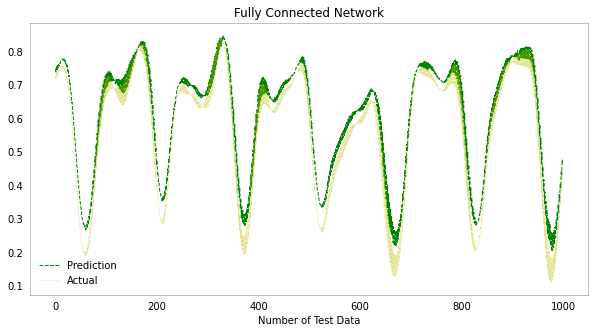

In [13]:
plt.figure(figsize = [10,5])
print(prediction.shape)
plt.plot(prediction[10000:13000:3, 8], label='Prediction', linewidth=1, c='g', linestyle='--')
plt.plot(test_label[10000:13000:3, 8], label='Actual', linewidth=0.5, c='y', linestyle=':')
plt.legend(frameon=False)
plt.xlabel('Number of Test Data')
plt.title("Fully Connected Network")
plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True)   
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
plt.savefig('/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/mlp_prediction.png', dpi = 300)

Text(0.5, 1.0, 'Simple RNN Network')

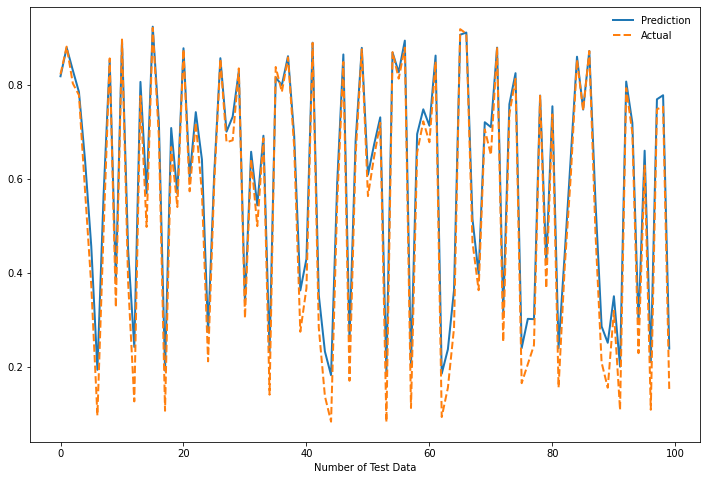

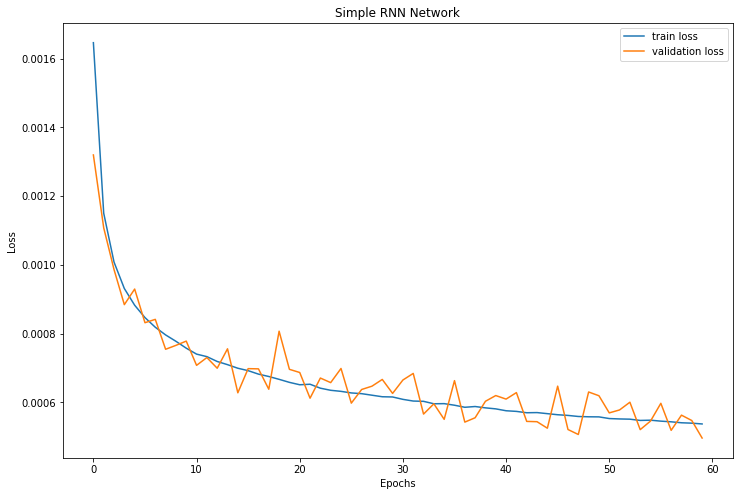

In [ ]:
plt.figure(figsize = [12,8])
test_data, test_label = shuffle(test_data, test_label, random_state=1)
prediction = model.predict(test_data)
plt.plot(prediction[0:100, 8], label='Prediction', linewidth=2,)
plt.plot(test_label[0:100, 8], label='Actual', linewidth=2, linestyle='--')
plt.legend(frameon=False)
plt.xlabel('Number of Test Data')
plt.savefig('destination_path.eps', format='eps')

history = trained_model.history
losses = history['loss']
val_losses = history['val_loss']

plt.figure(figsize = [12,8])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['train loss','validation loss'])
plt.title("Simple RNN Network")